# Toxic Comment Classification Challenge

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv.zip to sample_submission.csv.zip
Saving test_labels.csv.zip to test_labels.csv.zip
Saving test.csv.zip to test.csv.zip
Saving train.csv.zip to train.csv.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip test_labels.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
import pandas as pd

In [ ]:
original_test_labels = pd.read_csv("./test_labels.csv")
original_test = pd.read_csv("./test.csv")
original_train = pd.read_csv("./train.csv")

### Goal
1. Goal of the activity is not to find the best solution, but to udnerstand the process of evaluating the performance of different Machine Learning algorithms
2. Compare your performance to the leaderboard results

### Assignment Tasks
- [x] Perform detailed data analysis of the dataset
  - [x] Check if the dataset is unbalanced or not
  - [x] Number of senstences and tokens per class
  - [x] Analyse the most common words for each class and, therefore, understand the most used terms for each level of toxicity (Common words by toxicity)
- [x] Select three Machine Learning algorithms:
  - [x] Support Vector Machine (SVM)
  - [ ] ~~K-Nearest Neighbours (KNN)~~
  - [ ] ~~NaiveBayes~~
  - [ ] ~~Decision Trees~~
  - [x] Logistic Regression
  - [ ] ~~Random Forest~~
  - [x] Multi-Layer Perception
- [ ] Analyse their performance in classifying the level of toxicity of different comments. Use the main metrics to compare the different algorithms:
  - [x] Accuracy
  - [x] F1-score
  - [x] Recall
  - [x] Precision
  - [x] AUC
  - [x] Explain the parameters defined for each model
- [x] Consider the main Feature Extraction methods, TF-IDF and WordEmbeddings. Using the **same three classifier** change the Feature Extraction Method
  - [x] TF-IDF
  - [x] WordEmbeddings(GLOVE)
  - [x] Report on the performance difference
- [x] Submit your best algorithm to the competition page
  - [x] How good does it compare with other groups in the leaderboard
  - [x] Discuss the reason for that peformance
    - [x] What couldbe done to improve your proposed solution (maximum of two paragraphs)

- [x] Submit the final document
  - [x] Contain your responses for sub-tasks 1, 2, 3 and 4 in the form of a brief report (500 words)
  - [x] Please provide images, graphs, and tables for supporting your data analysis
  - [x] Python code must be included in your submission


# Import Libraries and Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import numpy as np
import spacy
import collections
from gensim.models import word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [ ]:
test_labels_df = original_test_labels
test_df = original_test
train_df = original_train

# Data Analysis

In [ ]:
# A brief look at the organisation of the data and its various classes 
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
129311,b39e7f6b1a797f88,Report errors here.,0,0,0,0,0,0
33161,58471d50d51732a9,"""\n\n Classic \nJimmy Wales stated, """"We need ...",0,0,0,0,0,0
132775,c6644bf714767ecc,"""\nIt looks like the source is a Guardian arti...",0,0,0,0,0,0
35878,5fde85e61575de73,"""\n\n COI and AFD \n\nI wont bother to join Wi...",1,0,0,0,0,0
139503,eab4d7298571512e,"OK, i leave it..... but you are all racists.",1,0,0,0,0,0


In [ ]:
# A random example of a toxic word from the dataset.
train_df[train_df["toxic"] == 1]["comment_text"][6]
# Ouch! that is toxic!

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [ ]:
# Lisitng toxic labels which show different categorisation of toxic words.
TOXIC_LABELS = list(train_df.columns.drop(["id", "comment_text"]))
print(TOXIC_LABELS)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [ ]:
# Checking for null values in dataset with .isnull method of pandas.
train_df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

## Stats

In [ ]:
# Using .describe method of pandas to analyze the statistics of dataset.
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Labels are 1 or 0, so .sum method  will help us in understanding the distribution of dataset.
label_sum = train_df[TOXIC_LABELS].sum()
label_sum

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

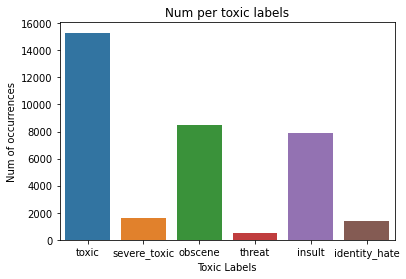

In [ ]:
# Plotting the distribution of labels against occurences shows the unbalanced nature of dataset.
plt.figure()
plt.title("Num per toxic labels")
plt.ylabel("Num of occurrences")
plt.xlabel("Toxic Labels")
ax = sns.barplot(x=label_sum.index, y=label_sum.values)

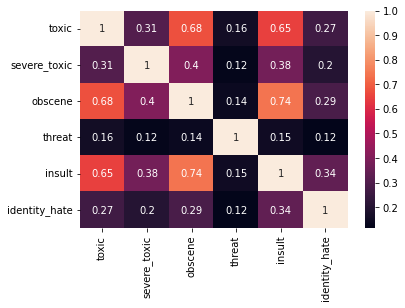

In [ ]:
# As the task of this assignment involves multi-label classification, it would be useful to understand the relationship between the labels and will also help with feature engineering.
corr = train_df.corr()
plt.figure()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

## Preprocessing Steps.

In [ ]:
train_df["comment_text"].head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
total_number_of_tokens = []
number_of_sentences = []
tokens = []
glove_vector = []

for doc in nlp.pipe(train_df['comment_text'].astype('unicode').values, batch_size=1000):
  tokens.append([token.lower_ for token in doc if token.is_alpha and not token.is_stop])
  total_number_of_tokens.append(len(doc))
  number_of_sentences.append(len(list(doc.sents)))
  glove_vector.append(doc.vector.tolist())

train_df['total_number_of_tokens'] = total_number_of_tokens
train_df['number_of_sentences'] = number_of_sentences
train_df["tokens"] = tokens
train_df["glove_vector"] = glove_vector

In [ ]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_number_of_tokens,number_of_sentences,tokens,glove_vector
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,50,4,"[explanation, edits, username, hardcore, metal...","[0.1826944351196289, 0.3525041937828064, -0.18..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,28,6,"[matches, background, colour, seemingly, stuck...","[0.19189171493053436, 0.40444040298461914, -0...."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,48,3,"[hey, man, trying, edit, war, guy, constantly,...","[0.10182995349168777, 1.1778610944747925, -0.0..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,133,10,"[real, suggestions, improvement, wondered, sec...","[0.08876579999923706, 0.4697527587413788, 0.01..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,18,2,"[sir, hero, chance, remember, page]","[-0.44703754782676697, 0.9699418544769287, -0...."


In [ ]:
# Number of tokens and number of sentences in each class.
for label in TOXIC_LABELS:
    for metric in ["total_number_of_tokens", "number_of_sentences"]:
      print(f"Label: {label}\t - Metric: {metric}: {train_df[train_df[label]==1][metric].sum()}")

Label: toxic	 - Metric: total_number_of_tokens: 998997
Label: toxic	 - Metric: number_of_sentences: 115812
Label: severe_toxic	 - Metric: total_number_of_tokens: 163241
Label: severe_toxic	 - Metric: number_of_sentences: 27112
Label: obscene	 - Metric: total_number_of_tokens: 529392
Label: obscene	 - Metric: number_of_sentences: 65949
Label: threat	 - Metric: total_number_of_tokens: 39104
Label: threat	 - Metric: number_of_sentences: 4938
Label: insult	 - Metric: total_number_of_tokens: 480209
Label: insult	 - Metric: number_of_sentences: 60787
Label: identity_hate	 - Metric: total_number_of_tokens: 89870
Label: identity_hate	 - Metric: number_of_sentences: 10433


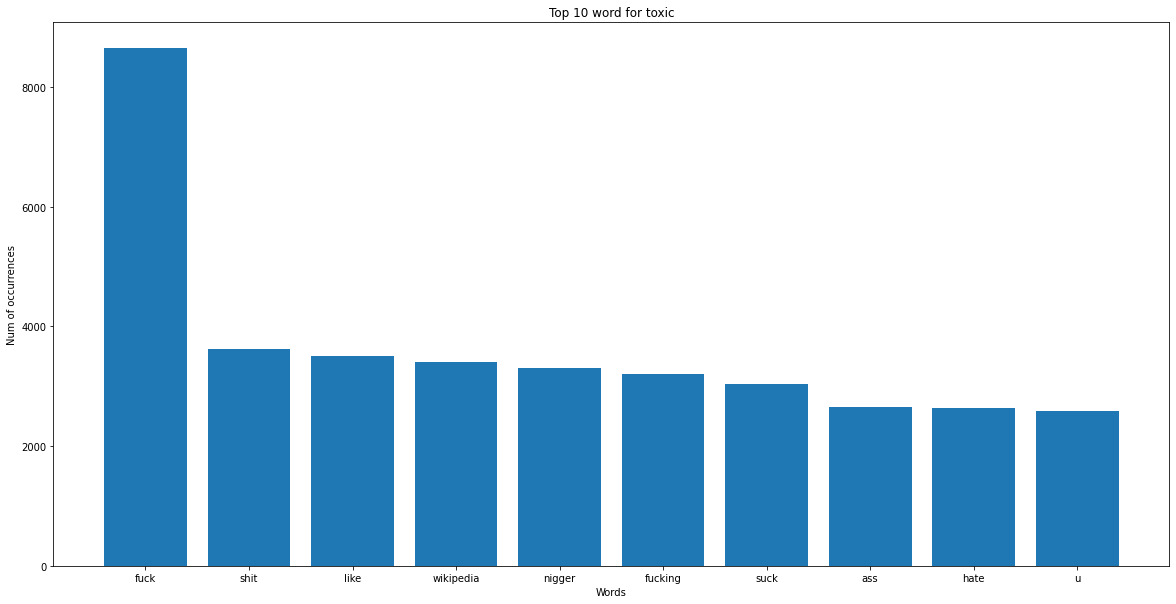

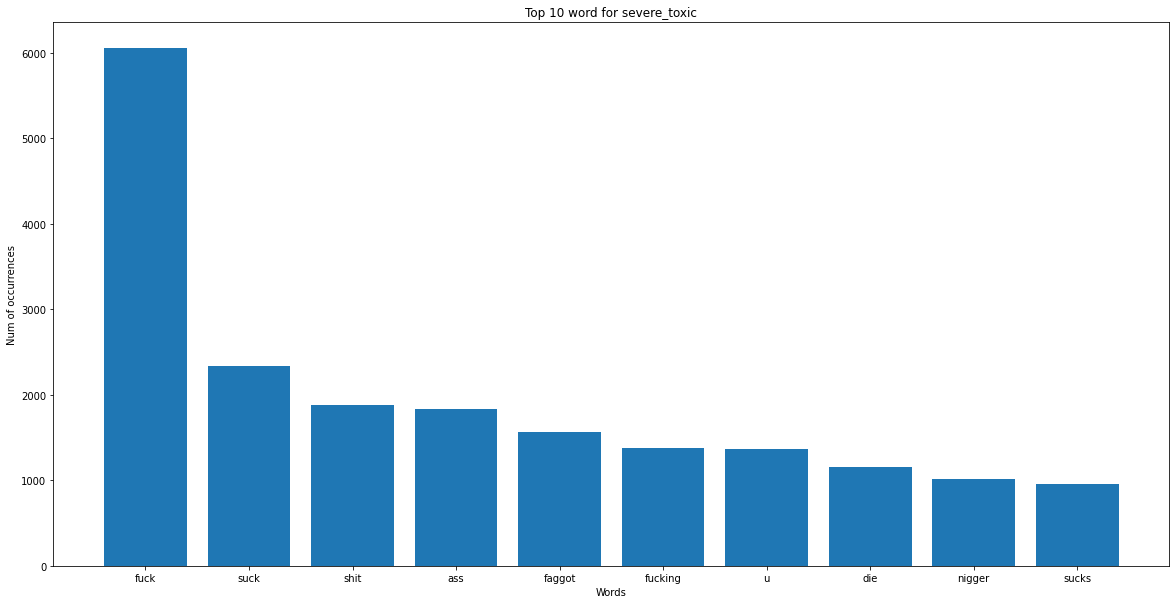

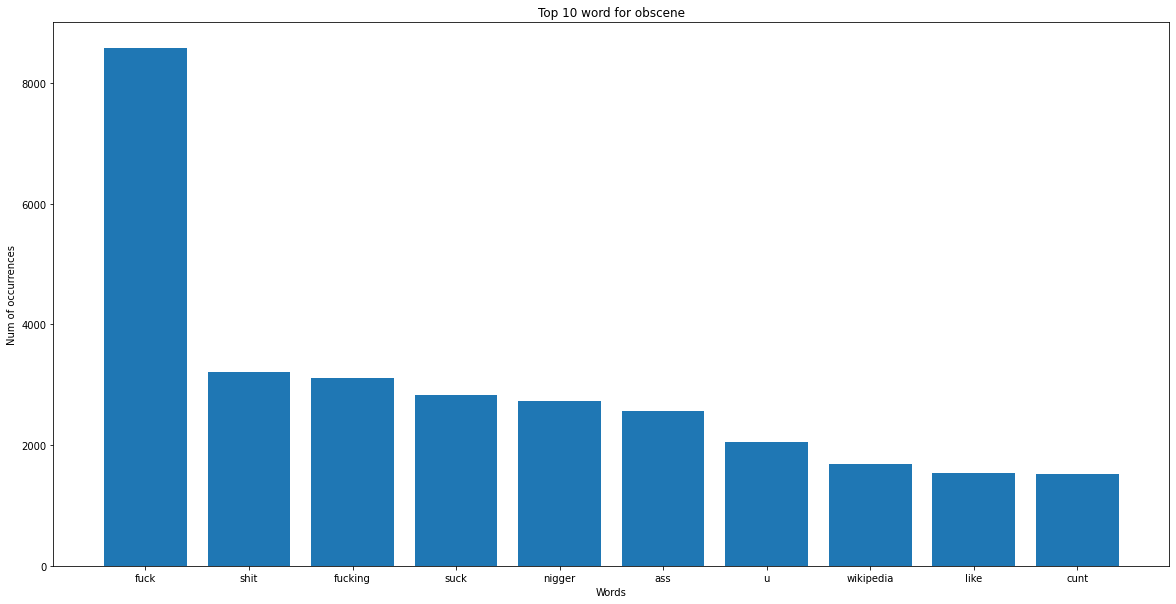

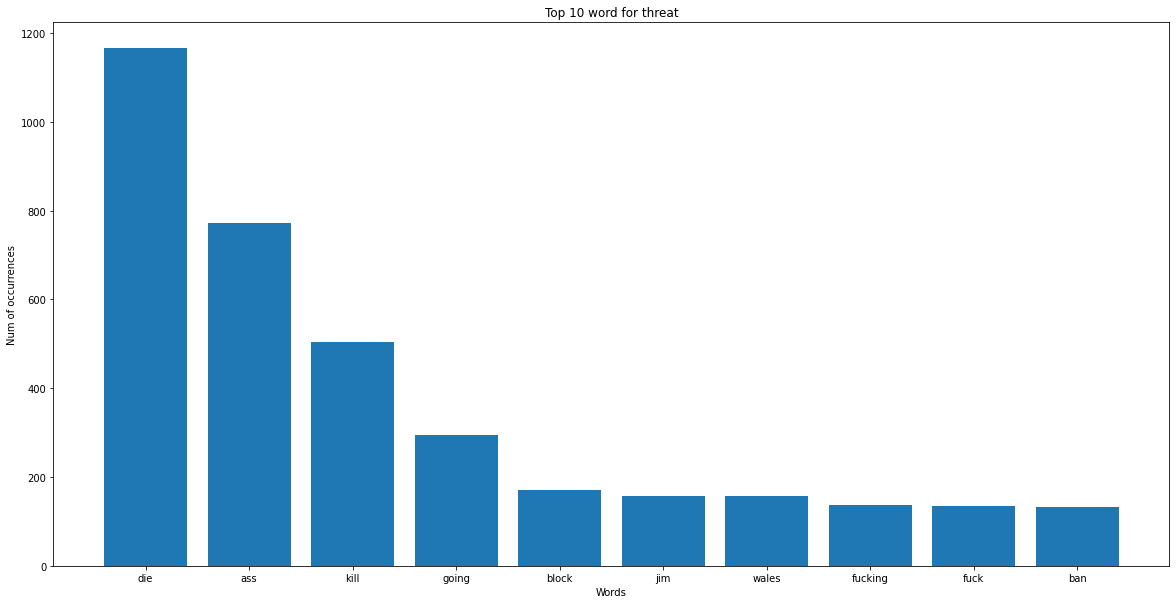

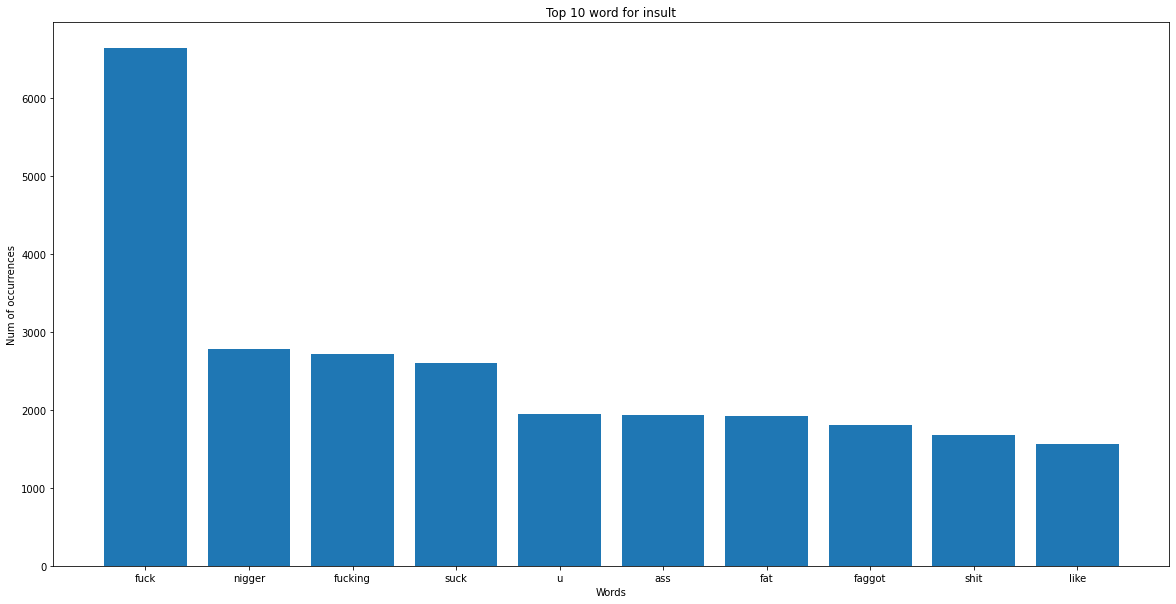

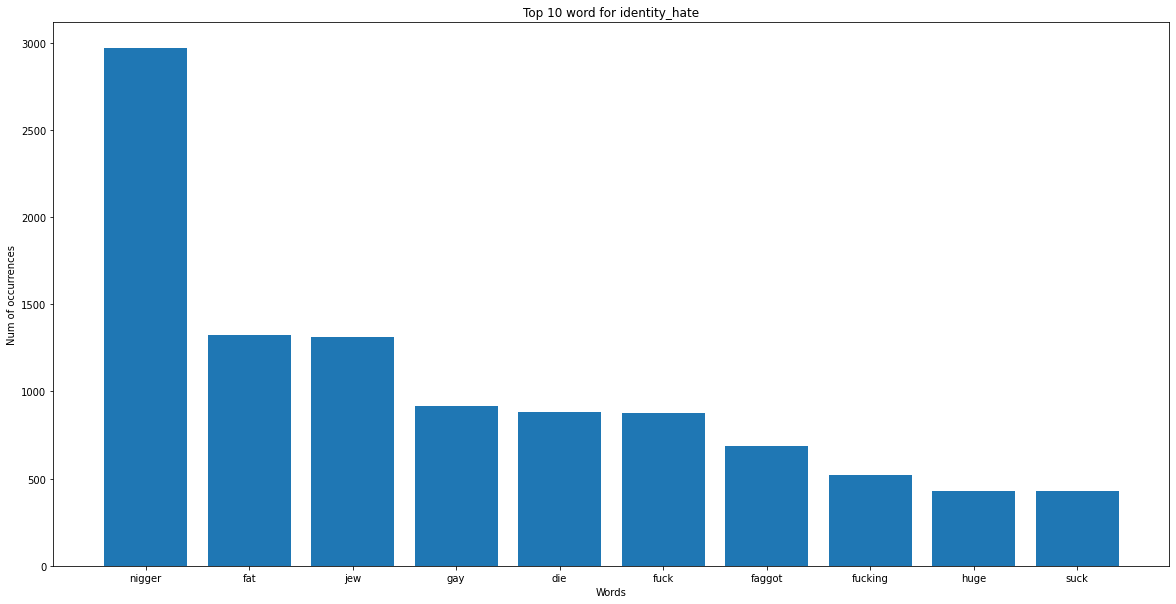

In [ ]:
for label in TOXIC_LABELS:
  words = list(train_df.loc[train_df[label] == 1, "tokens"].explode())
  top_10_common = collections.Counter(words).most_common(10)
  # create columns
  words_arr, counts_arr = [], []
  for w, c in top_10_common:
    words_arr.append(w)
    counts_arr.append(c)
  plt.figure(figsize=(20, 10))
  plt.title(f"Top 10 word for {label}")
  plt.ylabel("Num of occurrences")
  plt.xlabel("Words")
  plt.bar(x=words_arr, height=counts_arr)
  

# Application of Selected ML algorithms.

Algorithms selected Logistic Regression, SVM, Multi-Layer Perception using TF-IDF and GLOVE.

In [ ]:
# tf-idf vectors
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_df["comment_text"])
vectorizer

TfidfVectorizer(max_features=5000)

In [ ]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [ ]:
x_train = vectorizer.transform(train_df['comment_text'])

In [ ]:
val_cut_off = int(len(train_df)*0.8)
validation_set = train_df[val_cut_off:].copy()

# Logistic regression (TF-IDF)

In [ ]:
lr_classifier = LogisticRegression(solver='liblinear')
average_roc = 0
    
for label in TOXIC_LABELS:
    lr_classifier.fit(x_train[:val_cut_off], train_df[label][:val_cut_off])
    predictions = lr_classifier.predict(x_train[val_cut_off:])
    print(f'\nLabel = {label}')
    report = classification_report(validation_set[label], predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.to_markdown())
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}\n')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(TOXIC_LABELS)}')


Label = toxic
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.961478 | 0.99394  |   0.97744  | 28878        |
| 1            |    0.915131 | 0.621337 |   0.740145 |  3037        |
| accuracy     |    0.958483 | 0.958483 |   0.958483 |     0.958483 |
| macro avg    |    0.938304 | 0.807638 |   0.858792 | 31915        |
| weighted avg |    0.957068 | 0.958483 |   0.954859 | 31915        |
AUC: 0.8076384345593123


Label = severe_toxic
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.992511 | 0.99807  |   0.995283 | 31604        |
| 1            |    0.544776 | 0.234727 |   0.32809  |   311        |
| accuracy     |    0.990631 | 0.990631 |   0.990631 |     0.990631 |
| macro avg    |    0.768644 | 0.616398 |   0.661686 | 31915        |
| weighted avg |    0.988148

## Logistic regression (GLOVE)

In [ ]:
lr_classifier = LogisticRegression(solver='liblinear')
average_roc = 0
    
for label in TOXIC_LABELS:
    lr_classifier.fit(train_df["glove_vector"].to_list()[:val_cut_off], train_df[label][:val_cut_off])
    predictions = lr_classifier.predict(train_df["glove_vector"].to_list()[val_cut_off:])
    print(f'\nLabel = {label}')
    report = classification_report(validation_set[label], predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.to_markdown())
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}\n')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(TOXIC_LABELS)}')


Label = toxic
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.926527 | 0.985144 |   0.954937 | 28878       |
| 1            |    0.645455 | 0.257162 |   0.367789 |  3037       |
| accuracy     |    0.91587  | 0.91587  |   0.91587  |     0.91587 |
| macro avg    |    0.785991 | 0.621153 |   0.661363 | 31915       |
| weighted avg |    0.89978  | 0.91587  |   0.899064 | 31915       |
AUC: 0.6211530366425417


Label = severe_toxic
|              |   precision |    recall |   f1-score |      support |
|:-------------|------------:|----------:|-----------:|-------------:|
| 0            |    0.990897 | 0.998861  |   0.994863 | 31604        |
| 1            |    0.368421 | 0.0675241 |   0.11413  |   311        |
| accuracy     |    0.989785 | 0.989785  |   0.989785 |     0.989785 |
| macro avg    |    0.679659 | 0.533193  |   0.554497 | 31915        |
| weighted avg |    0.984831 

## SVM (TF-IDF)

In [ ]:
svm_classifier = SVC()
average_roc = 0
    
for label in TOXIC_LABELS:
    svm_classifier.fit(x_train[:val_cut_off], train_df[label][:val_cut_off])
    predictions = svm_classifier.predict(x_train[val_cut_off:])
    print(f'\nLabel = {label}')
    report = classification_report(validation_set[label], predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.to_markdown())
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}\n')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(TOXIC_LABELS)}')


Label = toxic
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.961906 | 0.994182 |   0.977778 | 28878       |
| 1            |    0.918762 | 0.625617 |   0.744368 |  3037       |
| accuracy     |    0.95911  | 0.95911  |   0.95911  |     0.95911 |
| macro avg    |    0.940334 | 0.8099   |   0.861073 | 31915       |
| weighted avg |    0.9578   | 0.95911  |   0.955567 | 31915       |
AUC: 0.8098999040916581


Label = severe_toxic
|              |   precision |    recall |   f1-score |      support |
|:-------------|------------:|----------:|-----------:|-------------:|
| 0            |    0.991152 | 0.999525  |   0.995321 | 31604        |
| 1            |    0.659091 | 0.0932476 |   0.16338  |   311        |
| accuracy     |    0.990694 | 0.990694  |   0.990694 |     0.990694 |
| macro avg    |    0.825121 | 0.546386  |   0.579351 | 31915        |
| weighted avg |    0.987916 

## SVM (GLOVE)

In [ ]:
svm_classifier = SVC()
average_roc = 0
    
for label in TOXIC_LABELS:
    svm_classifier.fit(train_df["glove_vector"].to_list()[:val_cut_off], train_df[label][:val_cut_off])
    predictions = svm_classifier.predict(train_df["glove_vector"].to_list()[val_cut_off:])
    print(f'\nLabel = {label}')
    report = classification_report(validation_set[label], predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.to_markdown())
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}\n')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(TOXIC_LABELS)}')


Label = toxic
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.923317 | 0.994009 |   0.95736  | 28878        |
| 1            |    0.790557 | 0.215015 |   0.338079 |  3037        |
| accuracy     |    0.919881 | 0.919881 |   0.919881 |     0.919881 |
| macro avg    |    0.856937 | 0.604512 |   0.64772  | 31915        |
| weighted avg |    0.910684 | 0.919881 |   0.89843  | 31915        |
AUC: 0.6045120488374754


Label = severe_toxic
|              |   precision |    recall |   f1-score |      support |
|:-------------|------------:|----------:|-----------:|-------------:|
| 0            |    0.99044  | 0.999873  |  0.995135  | 31604        |
| 1            |    0.6      | 0.0192926 |  0.0373832 |   311        |
| accuracy     |    0.990318 | 0.990318  |  0.990318  |     0.990318 |
| macro avg    |    0.79522  | 0.509583  |  0.516259  | 31915        |
| weighted avg |    0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Label = insult
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.955626 | 0.99822  |   0.976458 | 30333        |
| 1            |    0.765217 | 0.111252 |   0.19426  |  1582        |
| accuracy     |    0.954253 | 0.954253 |   0.954253 |     0.954253 |
| macro avg    |    0.860422 | 0.554736 |   0.585359 | 31915        |
| weighted avg |    0.946187 | 0.954253 |   0.937686 | 31915        |
AUC: 0.5547356704674197


Label = identity_hate
|              |   precision |     recall |   f1-score |      support |
|:-------------|------------:|-----------:|-----------:|-------------:|
| 0            |    0.990474 | 1          | 0.995214   | 31610        |
| 1            |    1        | 0.00327869 | 0.00653595 |   305        |
| accuracy     |    0.990475 | 0.990475   | 0.990475   |     0.990475 |
| macro avg    |    0.995237 | 0.501639   | 0.500875   | 31915        |
| weighted avg

## MLP (TF-IDF)

In [ ]:
mlp_classifier = MLPClassifier(max_iter=20)
average_roc = 0
    
for label in TOXIC_LABELS:
    mlp_classifier.fit(x_train[:val_cut_off], train_df[label][:val_cut_off])
    predictions = mlp_classifier.predict(x_train[val_cut_off:])
    print(f'\nLabel = {label}')
    report = classification_report(validation_set[label], predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.to_markdown())
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}\n')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(TOXIC_LABELS)}')

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = toxic
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.968098 | 0.981474 |   0.97474  | 28878        |
| 1            |    0.797195 | 0.69246  |   0.741145 |  3037        |
| accuracy     |    0.953971 | 0.953971 |   0.953971 |     0.953971 |
| macro avg    |    0.882646 | 0.836967 |   0.857943 | 31915        |
| weighted avg |    0.951835 | 0.953971 |   0.952511 | 31915        |
AUC: 0.8369667252077666



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = severe_toxic
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.993491 | 0.994874 |   0.994182 | 31604        |
| 1            |    0.393258 | 0.337621 |   0.363322 |   311        |
| accuracy     |    0.988469 | 0.988469 |   0.988469 |     0.988469 |
| macro avg    |    0.693375 | 0.666247 |   0.678752 | 31915        |
| weighted avg |    0.987642 | 0.988469 |   0.988035 | 31915        |
AUC: 0.6662473226759932



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = obscene
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.985416 | 0.989652 |   0.987529 | 30246        |
| 1            |    0.796621 | 0.734572 |   0.764339 |  1669        |
| accuracy     |    0.976312 | 0.976312 |   0.976312 |     0.976312 |
| macro avg    |    0.891019 | 0.862112 |   0.875934 | 31915        |
| weighted avg |    0.975543 | 0.976312 |   0.975858 | 31915        |
AUC: 0.8621115619644103



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = threat
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.998242 | 0.999214 |   0.998728 | 31823        |
| 1            |    0.590164 | 0.391304 |   0.470588 |    92        |
| accuracy     |    0.997462 | 0.997462 |   0.997462 |     0.997462 |
| macro avg    |    0.794203 | 0.695259 |   0.734658 | 31915        |
| weighted avg |    0.997066 | 0.997462 |   0.997206 | 31915        |
AUC: 0.6952593762509752



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = insult
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.978969 | 0.988297 |   0.983611 | 30333        |
| 1            |    0.725445 | 0.59292  |   0.652522 |  1582        |
| accuracy     |    0.968698 | 0.968698 |   0.968698 |     0.968698 |
| macro avg    |    0.852207 | 0.790608 |   0.818066 | 31915        |
| weighted avg |    0.966402 | 0.968698 |   0.967199 | 31915        |
AUC: 0.7906084643349673



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = identity_hate
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.993188 | 0.99633  |   0.994757 | 31610        |
| 1            |    0.434146 | 0.291803 |   0.34902  |   305        |
| accuracy     |    0.989597 | 0.989597 |   0.989597 |     0.989597 |
| macro avg    |    0.713667 | 0.644067 |   0.671888 | 31915        |
| weighted avg |    0.987846 | 0.989597 |   0.988586 | 31915        |
AUC: 0.6440667769589412

Average AUC: 0.7492100378988423


## MLP (GLOVE)

In [ ]:
mlp_classifier = MLPClassifier(max_iter=20)
average_roc = 0
    
for label in TOXIC_LABELS:
    mlp_classifier.fit(train_df["glove_vector"].to_list()[:val_cut_off], train_df[label][:val_cut_off])
    predictions = mlp_classifier.predict(train_df["glove_vector"].to_list()[val_cut_off:])
    print(f'\nLabel = {label}')
    report = classification_report(validation_set[label], predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.to_markdown())
    print(f'AUC: {roc_auc_score(validation_set[label], predictions)}\n')
    average_roc += roc_auc_score(validation_set[label], predictions)
                                 
print(f'Average AUC: {average_roc/len(TOXIC_LABELS)}')

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = toxic
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.933624 | 0.984867 |   0.958562 | 28878        |
| 1            |    0.699036 | 0.334211 |   0.452217 |  3037        |
| accuracy     |    0.922952 | 0.922952 |   0.922952 |     0.922952 |
| macro avg    |    0.81633  | 0.659539 |   0.705389 | 31915        |
| weighted avg |    0.911301 | 0.922952 |   0.910378 | 31915        |
AUC: 0.6595393829543212



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = severe_toxic
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.992751 | 0.996709 |   0.994726 | 31604        |
| 1            |    0.437838 | 0.26045  |   0.326613 |   311        |
| accuracy     |    0.989535 | 0.989535 |   0.989535 |     0.989535 |
| macro avg    |    0.715295 | 0.62858  |   0.66067  | 31915        |
| weighted avg |    0.987344 | 0.989535 |   0.988216 | 31915        |
AUC: 0.6285797190391871



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = obscene
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.961926 | 0.991503 |   0.976491 | 30246        |
| 1            |    0.652233 | 0.288796 |   0.400332 |  1669        |
| accuracy     |    0.954755 | 0.954755 |   0.954755 |     0.954755 |
| macro avg    |    0.807079 | 0.640149 |   0.688411 | 31915        |
| weighted avg |    0.94573  | 0.954755 |   0.94636  | 31915        |
AUC: 0.6401493473509235



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = threat
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.997335 | 0.99956  |   0.998446 | 31823        |
| 1            |    0.333333 | 0.076087 |   0.123894 |    92        |
| accuracy     |    0.996898 | 0.996898 |   0.996898 |     0.996898 |
| macro avg    |    0.665334 | 0.537824 |   0.56117  | 31915        |
| weighted avg |    0.995421 | 0.996898 |   0.995925 | 31915        |
AUC: 0.5378235115701114



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = insult
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.964402 | 0.988692 |   0.976396 | 30333        |
| 1            |    0.580685 | 0.300253 |   0.395833 |  1582        |
| accuracy     |    0.954567 | 0.954567 |   0.954567 |     0.954567 |
| macro avg    |    0.772543 | 0.644473 |   0.686115 | 31915        |
| weighted avg |    0.945381 | 0.954567 |   0.947618 | 31915        |
AUC: 0.6444725139656096



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Label = identity_hate
|              |   precision |    recall |   f1-score |      support |
|:-------------|------------:|----------:|-----------:|-------------:|
| 0            |    0.991138 | 0.997786  |   0.994451 | 31610        |
| 1            |    0.247312 | 0.0754098 |   0.115578 |   305        |
| accuracy     |    0.988971 | 0.988971  |   0.988971 |     0.988971 |
| macro avg    |    0.619225 | 0.536598  |   0.555014 | 31915        |
| weighted avg |    0.98403  | 0.988971  |   0.986052 | 31915        |
AUC: 0.5365976734899206

Average AUC: 0.6078603580616789
